# CSPB 3022 Final Project: <br>Apartment Rent Prediction

### **Jordon Young**


## Project Topic:

### Type: Regression

For this project, I would like to solve a regression problem. Given a few variables, I would like to be able to estimate the monthly rental price of an apartment.

The main focus of analysis will be on using some of all of the following variables to create a model:

- Number of bedrooms
- Number of bathrooms
- Whether pets are allowed
- Number of square feet


## Project Goals:

My motivation for this project is to explore data science and machine learning concepts by constructing a rudimendary regression model.

At this point, the focus it to make use of the variables that require only gentle cleaning. In the future, I would like to transform the text field data into usable features.


## Data Source (Tabulated):

The data for this project comes from UC Irvine's Machine Learning Repository: [Apartment for Rent Classifieds](https://doi.org/10.24432/C5X623). It comes with two CSV files containing 10k and 100k records. I'm choosing to use 100k samples so there is plenty of data to divide up for training and testing.

The file has 22 columns with a guarantee that `price` and `square_feet` are never empty. All columns will be listed and explained in the next section.

#### Citation:

Apartment for rent classified. (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5X623.


In [1]:
import datetime as dt
import numpy as np 

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap

import pandas as pd 
from scipy.stats import pearsonr
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

apartments = pd.read_csv("data/apartments_for_rent_classified_100K.csv", encoding="latin1", sep=";")

C:\Users\jordo\AppData\Local\Temp\ipykernel_15792\1019512474.py:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  apartments = pd.read_csv("data/apartments_for_rent_classified_100K.csv", encoding="latin1", sep=";")


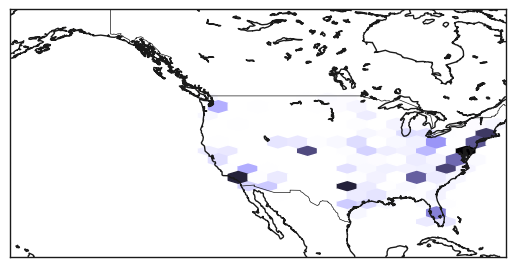

In [2]:
"""Plot apartment locations on map"""

# Remove rows with NaN values in the latitude or longitude columns
locations = apartments[["latitude", "longitude"]].dropna()

# Create a figure and axes
fig, ax = plt.subplots()

# Calculate the minimum and maximum longitude and latitude values
lon_min, lon_max = locations['longitude'].min(), locations['longitude'].max()
lat_min, lat_max = locations['latitude'].min(), locations['latitude'].max()

# Create a Basemap centered at the mean latitude and longitude of the locations
map = Basemap(
    projection='cyl',
    llcrnrlon=lon_min,
    llcrnrlat=lat_min,
    urcrnrlon=lon_max,
    urcrnrlat=lat_max,
    resolution='l',
    ax=ax
)

# Draw coastlines and country boundaries
map.drawcoastlines()
map.drawcountries()

# Set the background color of the map to white
map.drawmapboundary(fill_color='white')

# Create a custom colormap with three colors
cmap = LinearSegmentedColormap.from_list('custom', ['#fff', '#9f9aff', "#484272", '#030205'])

# Plot the longitude and latitude pairs as a density plot on the map
x, y = map(locations['longitude'].values, locations['latitude'].values)
map.hexbin(x, y, gridsize=25, cmap=cmap)

# Show the plot
plt.show()

## Data Cleaning, Exploration, and Univariate Analysis

In an attempt to make things easy to follow, I have all initial exploration, cleaning, and analysis broken down by variable. Additional processing (text fields to features) and multivariate analysis will be their own sections in the future.


In [3]:
apartments.columns.values.tolist()

['id',
 'category',
 'title',
 'body',
 'amenities',
 'bathrooms',
 'bedrooms',
 'currency',
 'fee',
 'has_photo',
 'pets_allowed',
 'price',
 'price_display',
 'price_type',
 'square_feet',
 'address',
 'cityname',
 'state',
 'latitude',
 'longitude',
 'source',
 'time']

#### `id`: nominal categorical

While represented as int64, these values are intended to be unique identifiers for listings. There are clearly 84 records that are not unique. I will drop duplicate rows.


In [4]:
id = apartments["id"]
print("Unique ids:", id.unique().size)
print("Total id records:", id.size)

Unique ids: 99408
Total id records: 99492


In [5]:
apartments = apartments[~apartments.duplicated()]
print("Unique ids:", apartments['id'].unique().size)
print("Total id records:", apartments['id'].size)

Unique ids: 99408
Total id records: 99408


In [6]:
apartments = apartments.drop(['id'], axis=1)

#### `category`: nominal categorical

It's not clear to me why there are redundant prefixes on these categories, or why the rental duration would be merged into the same variable as the type of building.

The only category of interest is `housing/rent/apartment`. The rest are extremely infrequent, so I'm going to drop them and focus on appartments only.


In [7]:
category = apartments["category"]
category.unique()

array(['housing/rent/apartment', 'housing/rent/home',
       'housing/rent/short_term', 'housing/rent', 'housing/rent/condo',
       'housing/rent/other', 'housing/rent/commercial/retail'],
      dtype=object)

In [8]:
category.value_counts()

category
housing/rent/apartment            99347
housing/rent/commercial/retail       42
housing/rent                          7
housing/rent/home                     4
housing/rent/short_term               4
housing/rent/condo                    3
housing/rent/other                    1
Name: count, dtype: int64

In [9]:
apartments = apartments[apartments['category'] == 'housing/rent/apartment']
apartments['category'].value_counts()

category
housing/rent/apartment    99347
Name: count, dtype: int64

In [10]:
apartments = apartments.drop(['category'], axis=1)

#### `title`: auxiliary information

The title variable appears to contain a wide range of styles and information. This is not immediately useful as a nominal categorical variable, but if processed, new attributes for each record could be created to add context to the listings. Every record has a title of some sort.


In [11]:
title = apartments["title"]
np.random.choice(title, 20).tolist()

['Two BR 2212 Regent St',
 'Two Spacious BR in Irvine. Single Car Garage!',
 'Move-in condition, Two BR One BA',
 'ENERGY STAR Certified community.',
 'Enjoy the good Village Apartments. Pet OK!',
 'Apartment only for $1,629/mo. You Can Stop Looking Now!',
 'Attractive One BR, One BA',
 'Commons is a beautiful apartment community located in Tewksbury, MA.',
 'One BR Apartment in Little Rock',
 'Three BR Apartment - Large & Bright. Pet OK!',
 'One BR - ready to move in.',
 '1 BR MarketOur 1 BR are 583sq ft. Pet OK!',
 'Beautiful San Antonio Apartment for rent. Pet OK!',
 'Our thoughts are with those in the path of Hurricane Florence.',
 '$1,450 / Two BR - Great Deal. MUST SEE. Washer/Dryer Hookups!',
 'Great Central Location Two BR, Two BA',
 'Bowling Green - 1bd/One BA 700sqft Apartment for rent',
 'Great Central Location Two BR, Two BA. Single Car Garage!',
 'Two BR, Two BA, safe neighborhood',
 'One Spacious BR in Lincoln. Single Car Garage!']

In [12]:
# There are no NaN values
title.isna().value_counts() / title.size

title
False    1.0
Name: count, dtype: float64

In [13]:
max_title_len = float('-inf')
min_title_len = float('inf')
title_lens = []
for t in title.tolist():
    title_lens.append(len(t))
    if len(t) < min_title_len:
        min_title_len = len(t)
    if len(t) > max_title_len:
        max_title_len = len(t)

print("Minimum Title Length:", min_title_len)
print("Maximum Title Length:", max_title_len)
print("Average Title Length:", np.mean(title_lens))
print("Median Title Length", np.median(title_lens))

Minimum Title Length: 3
Maximum Title Length: 80
Average Title Length: 43.4896373317765
Median Title Length 42.0


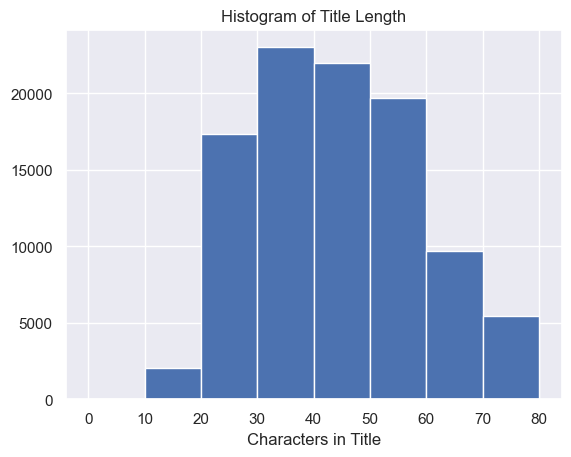

In [14]:
plt.hist(title_lens, bins=8, range=(0, 80))
plt.title("Histogram of Title Length")
plt.xlabel("Characters in Title")
plt.xticks(np.arange(0, 81, 10))
plt.show()

#### `body`: auxiliary information

Just like the title variable, the body variable contains a ton of extra information. It appears that often location, rent, and amenities are included in the description. If we are missing values for a record, it would be very helpful to be able to parse the tile and body to fill in missing information or add additional attributes gleaned from the description.


In [15]:
body = apartments["body"]
np.random.choice(body, 10).tolist()

['Square footage: 1102 square feet, unit number: 135754. FL is located on a private island within The Villages of Bayport, with convenient access to Downtown Tampa, Clearwater, and. Petersburg. Our upscale apartment interiors include kitchens and bathrooms with chestnut cabinetry, California closets, and energy efficient Whirlpool appliances. Every apartment home offers ceramic tile flooring with carpeting in the bedrooms. Our luxurious apartments have first floor entries, and upstairs apartment homes are designed with soaring ceilings and a bonus room that easily converts into an office or den. Island Walk is host to a variety of monthly social events, and residents enjoy resort -style amenities, including boardwalks along our fresh and salt water canals, fishing cabanas, swimming pools with outdoor living areas, state-of-the-art fitness centers, Wi-Fi cafe, theater room, tennis courts, and club house - leisure. the floor plans and image carousel of our Top-Rated Community.',
 'Find o

In [16]:
# There are no NaN values
body.isna().value_counts() / body.size

body
False    1.0
Name: count, dtype: float64

In [17]:
max_body_lens = float('-inf')
min_body_lens = float('inf')
body_lens = []
for b in body.tolist():
    body_lens.append(len(b))
    if len(b) < min_body_lens:
        min_body_lens = len(b)
    if len(b) > max_body_lens:
        max_body_lens = len(b)

print("Minimum Body Length:", min_body_lens) # There are no empty strings
print("Maximum Body Length:", max_body_lens)
print("Average Body Length:", np.mean(body_lens))
print("Median Body Length", np.median(body_lens))

Minimum Body Length: 6
Maximum Body Length: 315288
Average Body Length: 805.8535537056982
Median Body Length 921.0


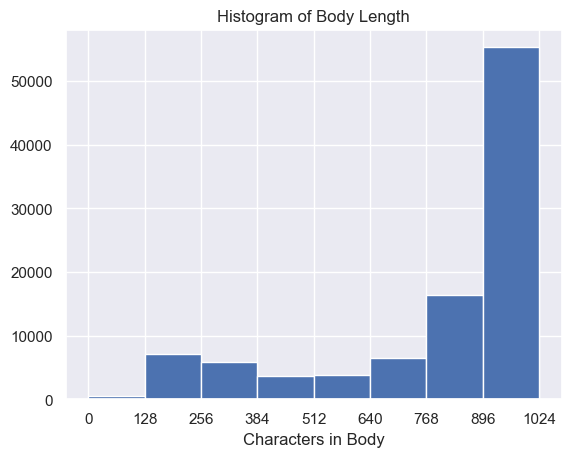

In [18]:
plt.hist(body_lens, bins=8, range=(0, 1024))
plt.title("Histogram of Body Length")
plt.xlabel("Characters in Body")
plt.xticks(np.arange(0, 1025, 128))
plt.show()

#### `amenities`: auxiliary information

There's a lot of work that needs to be done to process the amenities information, which is essentially a variable containing comma separated values. It is definitely helpful information, but the format is problematic because I can't compare or contrast them as they are. The only question I can answer is whether they have amenities and how long the string is. Even rentals without listed amenities have amenities, so this will be an interesting variable to investigate.


In [19]:
amenities = apartments["amenities"]
np.random.choice(amenities, 10).tolist()

[nan,
 'Dishwasher,Refrigerator',
 nan,
 'Parking,Storage',
 'Dishwasher,Fireplace,Garbage Disposal,Gated,Pool,Refrigerator',
 nan,
 nan,
 'Fireplace,Parking,Tennis',
 'Parking,Refrigerator',
 'Gym,Parking,Patio/Deck,Pool']

In [20]:
amenities.isna().value_counts() / amenities.size

amenities
False    0.838626
True     0.161374
Name: count, dtype: float64

As an exploration, I've gone through and extracted the possible values found in the amenities column. It would be helpful to create a new column for each of the amenities as a feature, and search through the titles and descriptions to see if these words appear. The format is somewhat inconsistent. Some keys have slashes, contractions, or spaces that are part of the amenity name.


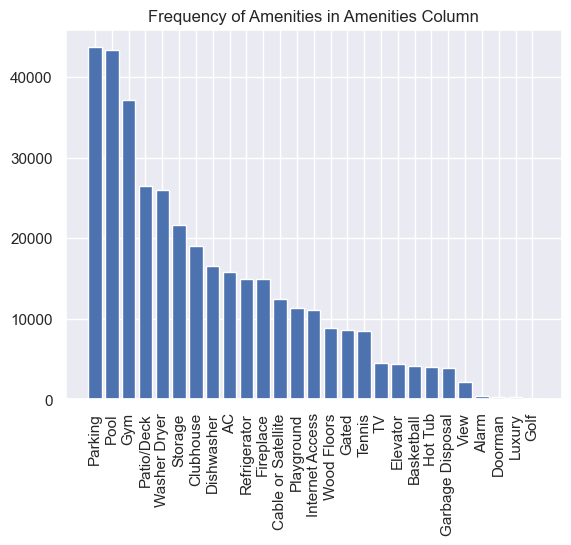

In [21]:
bag_of_amenities = {}

for amenity_list in amenities.dropna().tolist():
    words = amenity_list.split(',')
    for word in words:
        word = word.strip()
        if word in bag_of_amenities:
            bag_of_amenities[word] += 1
        else:
            bag_of_amenities[word] = 1

amenities_processed = pd.Series(bag_of_amenities).sort_values(ascending=False)

plt.bar(x=amenities_processed.index, height=amenities_processed.values)
plt.xticks(rotation=90)
plt.title("Frequency of Amenities in Amenities Column")
plt.show()

#### `bathrooms`: numerical discrete

The values range from 1.0 to 9.0, including the possibility of NaN. It looks like very few of the records are NaN, so I'm going to drop them.


In [22]:
bathrooms = apartments["bathrooms"]
bathrooms.value_counts().sort_index()

bathrooms
1.0    56230
1.5     3165
2.0    36514
2.5     2078
3.0      888
3.5      208
4.0      120
4.5       42
5.0       20
5.5        4
6.0        8
7.0        3
7.5        1
8.0        2
8.5        1
9.0        1
Name: count, dtype: int64

In [23]:
bathrooms.isna().value_counts() / bathrooms.size

bathrooms
False    0.999376
True     0.000624
Name: count, dtype: float64

In [24]:
apartments = apartments[apartments['bathrooms'].notna()]
apartments['bathrooms'].isna().value_counts() / apartments['bathrooms'].size

bathrooms
False    1.0
Name: count, dtype: float64

In [25]:
bathrooms = apartments["bathrooms"]

print("Minimum Bathrooms:", bathrooms.min())
print("Maximum Bathrooms:", bathrooms.max())
print("Mean Bathrooms:", bathrooms.mean())
print("Median Bathrooms", bathrooms.median())

Minimum Bathrooms: 1.0
Maximum Bathrooms: 9.0
Mean Bathrooms: 1.445268670997633
Median Bathrooms 1.0


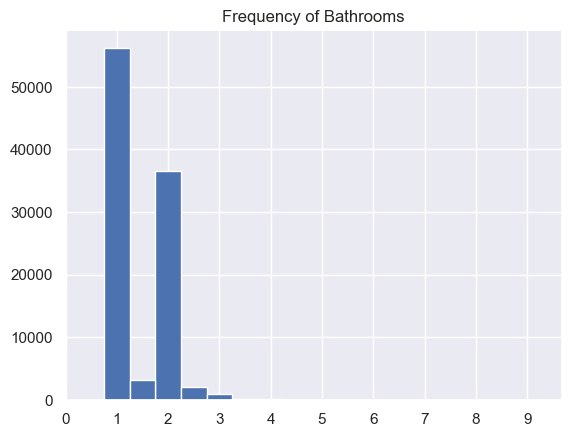

In [26]:
bathroom_counts = bathrooms.value_counts()
bathroom_counts.sort_index()

plt.bar(x=bathroom_counts.index, height=bathroom_counts, width=0.5)
plt.title("Frequency of Bathrooms")
plt.xticks(np.arange(0,10,1))
plt.show()

#### `bedrooms`: numerical discrete

NaN in the context of a bedroom could either mean a studio or missing information. A bedroom count of 0 is certainly a studio, but NaN is problematic. Luckily very few of the records have NaN for bedrooms, so I'm going to drop them.


In [27]:
bedrooms = apartments["bedrooms"]
bedrooms.value_counts().sort_index()

bedrooms
0.0      645
1.0    40251
2.0    45891
3.0    10538
4.0     1498
5.0      285
6.0       46
7.0        4
8.0        3
9.0        1
Name: count, dtype: int64

In [28]:
bedrooms.isna().value_counts() / bedrooms.size

bedrooms
False    0.998761
True     0.001239
Name: count, dtype: float64

In [29]:
apartments = apartments[apartments['bedrooms'].notna()]
apartments['bedrooms'] = apartments['bedrooms'].astype('int64')

apartments['bedrooms'].isna().value_counts() / apartments['bedrooms'].size

bedrooms
False    1.0
Name: count, dtype: float64

In [30]:
bedrooms = apartments["bedrooms"]

print("Minimum Bedrooms:", bedrooms.min())
print("Maximum Bedrooms:", bedrooms.max())
print("Mean Bedrooms:", bedrooms.mean())
print("Median Bedrooms", bedrooms.median())

Minimum Bedrooms: 0
Maximum Bedrooms: 9
Mean Bedrooms: 1.7284947863092717
Median Bedrooms 2.0


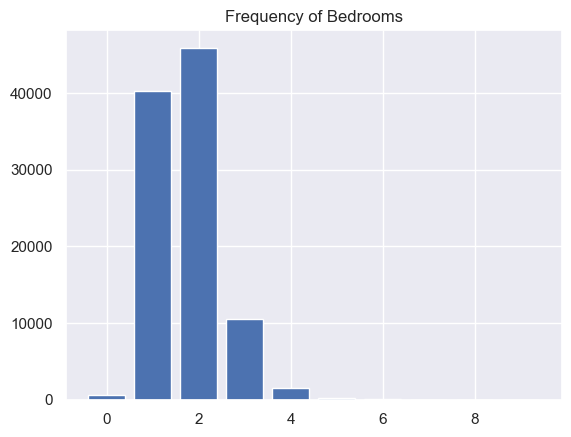

In [31]:
bedroom_counts = bedrooms.value_counts()
bedroom_counts.sort_index()

plt.bar(x=bedroom_counts.index, height=bedroom_counts)
plt.title("Frequency of Bedrooms")
plt.show()

#### `currency`: nominal categorical

The only value for currency in this dataset is USD, so I'm going to drop it.


In [32]:
currency = apartments["currency"]
currency.unique().tolist()

['USD']

In [33]:
apartments = apartments.drop(['currency'], axis=1)

#### `fee`: nominal categorical

This variable doesn't make sense to me, and the only description given on the source website is that this is a `fee`. It looks like less than 2% of records charge a fee. This isn't a variable I want to explore further, so I'm going to remove the `Yes` fees and drop the column.


In [34]:
fee = apartments["fee"]
fee.value_counts() / fee.size

fee
No     0.998013
Yes    0.001987
Name: count, dtype: float64

In [35]:
apartments = apartments[apartments['fee'] == 'No']
apartments = apartments.drop(['fee'], axis=1)

#### `has_photo`: categorical

This is a strange variable. It sounds like it would be boolean, but it actually has three categories. What's the difference between `Thumbnail` and `Yes`? If a record has `Yes`, does that mean it also had a `thumbnail`? This variable seems like it would contain a lot of incorrectly assigned values. Since I'm not sure what it means, I can't draw conclusions from analyzing it. I'll drop it.


In [36]:
has_photo = apartments["has_photo"]
has_photo.value_counts()

has_photo
Yes          55798
Thumbnail    33996
No            9171
Name: count, dtype: int64

In [37]:
apartments = apartments.drop(['has_photo'], axis=1)

#### `pets_allowed`: categorical

It seems like there is a natural ordering progressing from no pets to cats to dogs to cats and dogs. It's an abstracted scale of pet friendliness, but I don't know how useful it will be in its current state. I don't agree with the use of NaN here because in most contexts it suggests missing data. What is 'Cats,Dogs,None'? I'll take that to mean an option. I'm going to replace it with `True` for pets_allowed and `False` for pets not allowed.


In [38]:
pets_allowed = apartments["pets_allowed"]
pets_allowed.unique().tolist()

['Cats', 'Cats,Dogs', nan, 'Dogs', 'Cats,Dogs,None']

In [39]:
pets_allowed = pets_allowed.replace('Cats', True)
pets_allowed = pets_allowed.replace('Dogs', True)
pets_allowed = pets_allowed.replace('Cats,Dogs', True)
pets_allowed = pets_allowed.replace('Cats,Dogs,None', True)
pets_allowed = pets_allowed.fillna(False)
pets_allowed = pets_allowed.astype(bool)

apartments['pets_allowed'] = pets_allowed
apartments['pets_allowed'].value_counts()

pets_allowed
False    60039
True     38926
Name: count, dtype: int64

In [40]:
pets_allowed.value_counts().sum() # Expected number of true

98965

#### `price`: numerical discrete

This is the price per installment. Read on for an explanation of what I mean by installments. There is one NaN value. I'm going to remove it and cast the whole thing to integers since that's what they are.


In [41]:
price = apartments["price"]
np.random.choice(price, 10).tolist()

[2133.0, 1311.0, 2831.0, 505.0, 1814.0, 2190.0, 1495.0, 1213.0, 1299.0, 2005.0]

In [42]:
price.isna().value_counts()

price
False    98964
True         1
Name: count, dtype: int64

In [43]:
apartments = apartments[apartments['price'].notna()]
apartments['price'] = apartments['price'].astype(int)
apartments['price'].describe()

count    98964.000000
mean      1526.255962
std        899.047976
min        200.000000
25%       1015.000000
50%       1350.000000
75%       1795.000000
max      52500.000000
Name: price, dtype: float64

#### `price_display`: mixed / improper format

The price is guaranteed to exist for every record. This appears to be a human friendly string representation of the price per installment, so I'm going to drop it. It's entirely redundant.


In [44]:
price_display = apartments["price_display"]
np.random.choice(price_display, 5).tolist()

['$2,049', '$720', '$1,773', '$2,710', '$1,900']

In [45]:
apartments = apartments.drop(['price_display'], axis=1)

#### `price_type`: categorical

This is the installment type, or frequency of payment. The hybrid category of `Monthly|Weekly` allows either, but does not clearly describe what frequency is used in the `price` variable (depending on how data is cleaned before this point, these records may have already been removed for another reason).

It might help to "normalize" the price variable by converting everything to monthly, but since there are only three I'll drop them as outliers. Specifically, I'll drop those three rows and remove the column.


In [46]:
price_type = apartments["price_type"]
price_type.value_counts()

price_type
Monthly    98961
Weekly         3
Name: count, dtype: int64

In [47]:
apartments = apartments[apartments['price_type'] == 'Monthly']
apartments['price_type'].value_counts()

price_type
Monthly    98961
Name: count, dtype: int64

In [48]:
apartments = apartments.drop(['price_type'], axis=1)

#### `square_feet`: numerical discrete

Besides price, this is the only other variable guaranteed to have a non-NaN value besides price.


In [49]:
square_feet = apartments["square_feet"]
np.random.choice(square_feet, 10).tolist()

[640, 1708, 800, 1175, 653, 820, 1123, 771, 770, 789]

In [50]:
square_feet.describe()

count    98961.000000
mean       955.942078
std        365.141823
min        107.000000
25%        730.000000
50%        900.000000
75%       1115.000000
max      12000.000000
Name: square_feet, dtype: float64

#### `address`: nominal categorical

This is only the street address of the listing. It could be NaN. I don't think I'll use it for my project since I'm not clustering.


In [51]:
address = apartments["address"]
np.random.choice(address, 5).tolist()

[nan, nan, nan, nan, nan]

In [52]:
address.isna().value_counts()

address
True     91174
False     7787
Name: count, dtype: int64

#### `cityname`: nominal categorical

It's the name of the city for the listing. It could be NaN.


In [53]:
cityname = apartments["cityname"]
np.random.choice(cityname, 5).tolist()

['Colorado Springs', 'Arlington', 'Jersey City', 'Goodyear', 'Sandy']

In [54]:
cityname.isna().value_counts()

cityname
False    98663
True       298
Name: count, dtype: int64

#### `state`: nominal categorical

It's the name of the state for the listing. It could be NaN.


In [55]:
state = apartments["state"]
np.random.choice(state, 10).tolist()

['TX', 'MO', 'CA', 'NJ', 'CO', 'NC', 'CA', 'NJ', 'UT', 'VA']

In [56]:
state.isna().value_counts()

state
False    98663
True       298
Name: count, dtype: int64

In [57]:
state.value_counts()

state
TX    11219
CA    10237
VA     8264
NC     6289
CO     6267
FL     5761
MD     5229
MA     4924
OH     4889
GA     4743
NJ     4432
NV     2810
WA     2591
AZ     2368
LA     1344
MO     1201
PA     1114
TN     1111
IL     1026
NE     1019
KY      985
OK      931
SC      906
KS      891
UT      809
ND      739
NH      733
MI      709
NY      649
AR      597
MN      578
CT      504
IN      500
WI      428
IA      371
AL      351
OR      276
VT      125
RI      119
MS      107
ID       90
MT       87
SD       85
DC       83
AK       57
HI       31
ME       28
NM       22
WY       16
WV       12
DE        6
Name: count, dtype: int64

#### `latitude` and `longitude`: numerical continuous

The location of the listing. I used it at the top of the document to plot listings on a map. If clustering, it would be much better to use `latitude` and `longitude` than address/city/state because of missing information there.


In [58]:
latitude = apartments["latitude"]
np.random.choice(latitude, 5).tolist()

[39.8163, 38.2006, 36.8139, 35.6775, 32.3126]

In [59]:
longitude = apartments["longitude"]
np.random.choice(longitude, 5).tolist()

[-77.3421, -73.9287, -81.7893, -94.6911, -74.0644]

In [60]:
latitude.isna().value_counts()

latitude
False    98936
True        25
Name: count, dtype: int64

In [61]:
longitude.isna().value_counts()

longitude
False    98936
True        25
Name: count, dtype: int64

#### `source`: nominal categorical

Each record is a listing scraped from the internet. The source website can be found in this variable. It's interesting to see the names of the source websites as they are far from the most popular sites in the US (examples: Zillow, Apartments.com, Rent.com).

It might be wise to remove all sources from RENTCafe downward, but for now I'll leave them all and show a few samples.


In [62]:
source = apartments['source']
source.value_counts()

source
RentDigs.com         90661
RentLingo             6891
ListedBuy              553
GoSection8             434
RealRentals            268
RENTCafé                41
Listanza                25
RENTOCULAR              18
tenantcloud             17
RentFeeder              12
Home Rentals             8
SpreadMyAd               7
rentbits                 5
vFlyer                   5
Claz                     4
Nest Seekers             3
Seattle Rentals          2
Real Estate Agent        1
Real Estate Shows        1
Apartable                1
Z57                      1
FreeAdsTime              1
AgentWebsite             1
HousesForRent            1
Name: count, dtype: int64

In [63]:
apartments[apartments['source'] == 'RENTCafé'].head()

,title,body,amenities,bathrooms,bedrooms,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source,time
7112,The Oasis - B1,"Oasis is located at 9690 Forest Lane Dallas, T...",AC,1.0,2,True,995,875,9690 Forest Ln,Dallas,TX,32.9108,-96.7321,RENTCafé,1576253157
50409,Modera Metro Dadeland West - West-A02,Receive waived app and admin charges on all ho...,NaN,1.0,1,True,1782,639,8215 S.W 72nd Avenue,Miami,FL,25.7028,-80.2974,RENTCafé,1565878583
50410,Modera Metro Dadeland West - West-B06,Receive waived app and admin charges on all ho...,NaN,2.0,2,True,2882,1328,8215 S.W 72nd Avenue,Miami,FL,25.7028,-80.2974,RENTCafé,1565878595
50427,Oakton Park Apartments - One BR (1B),"Oakton Park offers beautiful one, 2 and 3 beds...","Patio/Deck,Pool,Washer Dryer,Wood Floors",1.0,1,True,1660,746,3347 Willow Crescent Dr,Fairfax,VA,38.8361,-77.3389,RENTCafé,1567176759
50428,2817 E 77th St - Two BR One BA Apartment,"This seven-plex in South Shore, Chicago featur...","Cable or Satellite,Wood Floors",1.0,2,True,810,800,2817 E 77th St,Chicago,IL,41.7620,-87.5704,RENTCafé,1567264754


#### `time`: numerical discrete

The timestamp the record was pulled from the source. It is in POSIX / UNIX format. It might be helpful to convert to datetime.


In [64]:
time = apartments['time']
time.describe()

count    9.896100e+04
mean     1.559627e+09
std      1.104604e+07
min      1.544174e+09
25%      1.550832e+09
50%      1.568745e+09
75%      1.568767e+09
max      1.577361e+09
Name: time, dtype: float64

## Cleaned Data

The cleaning process reduced the number of columns from 22 to 15. I only removed the data which was nonsense or redundant. I have no intention of using the location information, but it would be reasonable to use.

Even though I removed bad data, I haven't processed the title, body, and amenities columns and extracted them into features. This seems like a complex task, so for now I will make use of the data that I can immediately work with.

The cleaned data is printed below. For simplification, a copy with only the variables of interest is created in the next section.


In [65]:
apartments.head()

,title,body,amenities,bathrooms,bedrooms,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source,time
0,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1,True,2195,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3,True,1250,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340
2,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2.0,3,False,1395,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1577360332
3,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1.0,2,True,1600,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1577360330
4,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1.0,1,True,975,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1577360308


## Multivariate Analysis

- Number of Bathrooms
- Number of Bedrooms
- Whether Pets are allowed
- Monthly Rental Price
- Square Feet


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


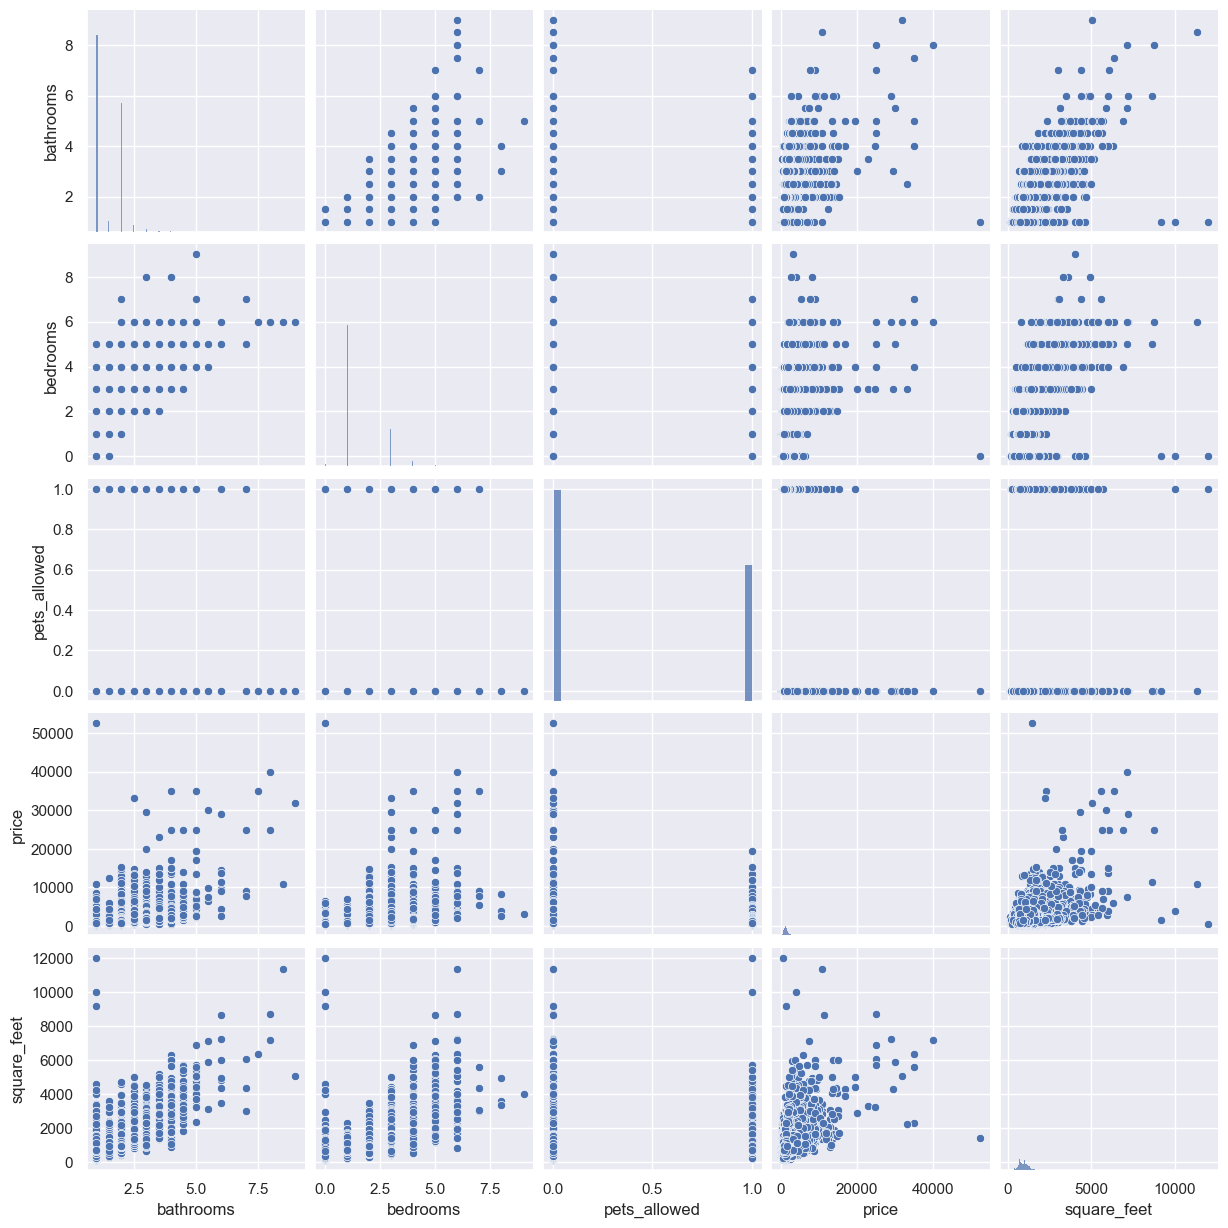

In [66]:
# apartments = apartments.drop(['title', 'body', 'amenities', 'address', 'cityname', 'state', 'latitude', 'longitude', 'time'], axis=1)
apts = apartments[['bathrooms', 'bedrooms', 'pets_allowed', 'price', 'square_feet']]
sns.pairplot(apts);

Immediately from this pair-plot there are some obvious associations.

Positive associations:

- square_feet and bathrooms
- square_feet and bedrooms
- square_feet and price
- bedrooms and bathrooms

Negative associations:

- square_feet and pets_allowed (first glance judgement, could be wrong)

None of the positive associations are shocking to me—generally more space is divided into more beds/bathrooms, and that costs more. I'm not sure if I'm reading the plot correctly, but it looks like larger apartments (probably more expensive apartments) do not allow pets.


### Correlation


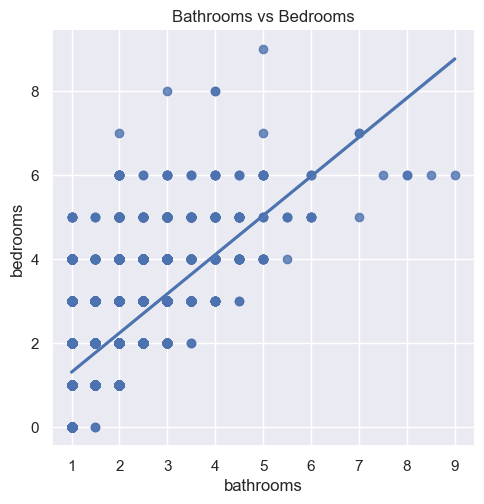

Correlation coefficient: 0.68




In [67]:
# bathrooms vs bedrooms
sns.lmplot(data=apts, x='bathrooms', y='bedrooms')
plt.title('Bathrooms vs Bedrooms')
plt.show()
corr, _ = pearsonr(apts['bathrooms'], apts['bedrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

Since bedrooms and bathrooms are strongly correlated, it might be problematic to include both in the model.


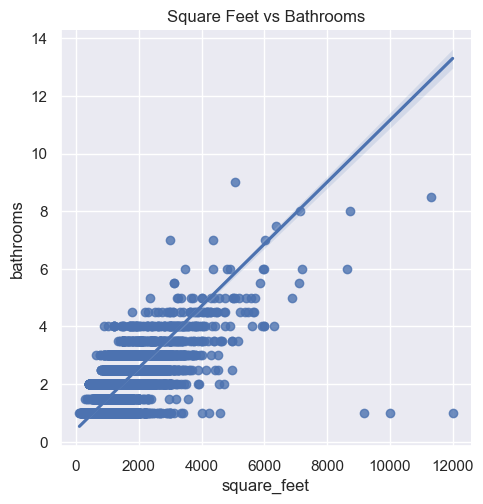

Correlation coefficient: 0.72




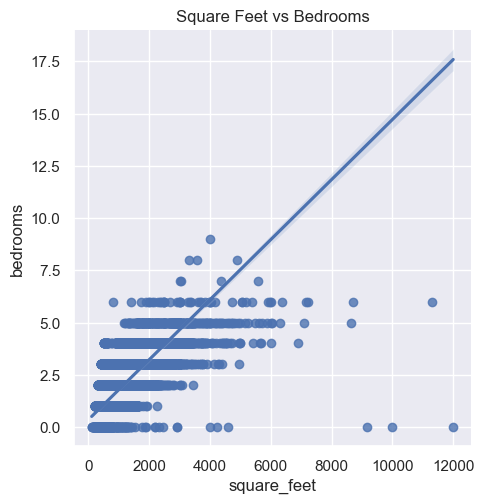

Correlation coefficient: 0.70




In [68]:
# square_feet vs bathrooms
sns.lmplot(data=apts, x='square_feet', y='bathrooms')
plt.title('Square Feet vs Bathrooms')
plt.show()
corr, _ = pearsonr(apts['square_feet'], apts['bathrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# square_feet vs bedrooms
sns.lmplot(data=apts, x='square_feet', y='bedrooms')
plt.title('Square Feet vs Bedrooms')
plt.show()
corr, _ = pearsonr(apts['square_feet'], apts['bedrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

Another unsurprising observation is that the number of bedrooms and bathrooms heavily influence the square footage of the apartment. The high correlation of variables could be problematic.


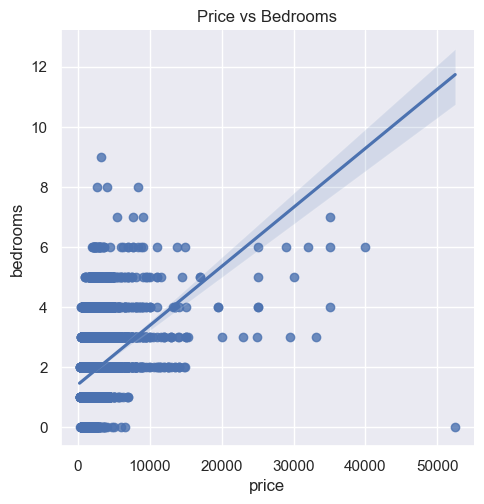

Correlation coefficient: 0.24




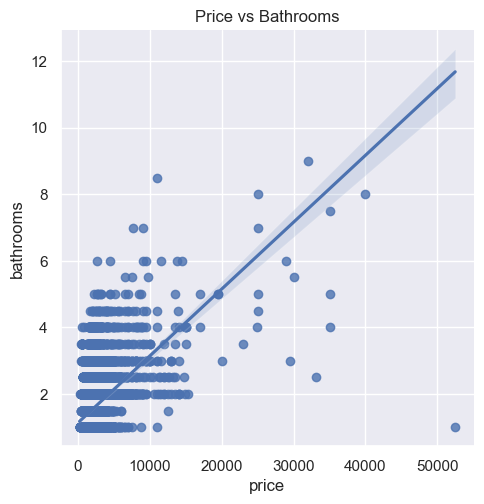

Correlation coefficient: 0.33




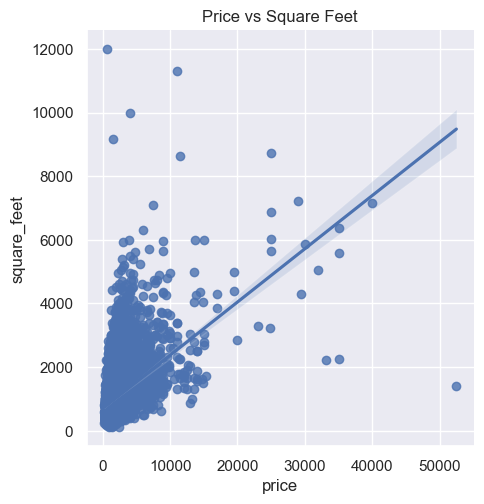

Correlation coefficient: 0.41




In [69]:
# price vs bedrooms
sns.lmplot(data=apts, x='price', y='bedrooms')
plt.title('Price vs Bedrooms')
plt.show()
corr, _ = pearsonr(apts['price'], apts['bedrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# price vs bathrooms
sns.lmplot(data=apts, x='price', y='bathrooms')
plt.title('Price vs Bathrooms')
plt.show()
corr, _ = pearsonr(apts['price'], apts['bathrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# price vs square_feet
sns.lmplot(data=apts, x='price', y='square_feet')
plt.title('Price vs Square Feet')
plt.show()
corr, _ = pearsonr(apts['price'], apts['square_feet'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

The three correlations above are weaker than the correlation between bedrooms, bathrooms, and square footage. It will be interesting to play around with the model--according to these plots, square foot and price are more strongly correlated than bedrooms and price and bathrooms and price.


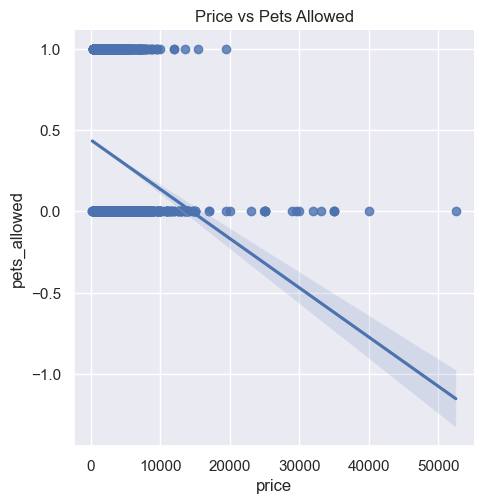

Correlation coefficient: -0.06




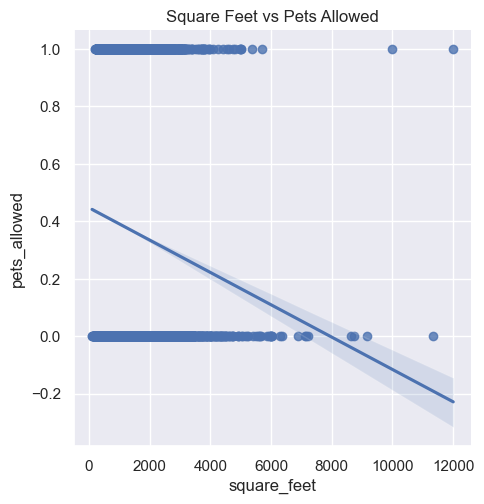

Correlation coefficient: -0.04




In [70]:
# price vs pets_allowed
sns.lmplot(data=apts, x='price', y='pets_allowed')
plt.title('Price vs Pets Allowed')
plt.show()
corr, _ = pearsonr(apts['price'], apts['pets_allowed'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# square_feet vs pets_allowed
sns.lmplot(data=apts, x='square_feet', y='pets_allowed')
plt.title('Square Feet vs Pets Allowed')
plt.show()
corr, _ = pearsonr(apts['square_feet'], apts['pets_allowed'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

The correlation between pets_allowed and price/square feet is approaching statistical insignificance. It's such a weak correlation that I will remove it as a factor.

I'm not surprised by the findings thus far, but I am concerned that the variables I've chosen my not create an accurate model since they are so strongly correlated with one another. A much more accurate model (provided the data was complete) making use of the amenities may create a more accurate model, but the complexity and processing necessary to create those feature columns is out of scope for this project.

Here's a summary of the correlations:


In [71]:
apts[['bathrooms', 'bedrooms', 'pets_allowed', 'price', 'square_feet']].corr()

,bathrooms,bedrooms,pets_allowed,price,square_feet
bathrooms,1.000000,0.680933,-0.009056,0.329724,0.716533
bedrooms,0.680933,1.000000,-0.024415,0.235773,0.701019
pets_allowed,-0.009056,-0.024415,1.000000,-0.055763,-0.042120
price,0.329724,0.235773,-0.055763,1.000000,0.411659
square_feet,0.716533,0.701019,-0.042120,0.411659,1.000000


## Model Construction, Training, and Testing


For this model, I think it would be simplest to use a linear regression. There are really only a few variables to play with in the model:

- square_feet
- bathrooms
- bedrooms

The price would be the prediction.

There is definitely not an over abundance of variables, so my main concern is that these three variables will not give an accurate enough prediction and that they are too collinear.

If the model turns out not to be very accurate, that may be the end of the project, but a much more feature rich model using text parsed to amenity features would be a fun next step.

First, let's divide the data into chunks for training and testing.


In [72]:
training_size = int(len(apts) * 0.80)
training = apts.sample(n=training_size, random_state=1)
testing = apts.loc[apts.index.difference(training.index)]

I've chosen to create a simple linear regression. I'll do a few variations below.


##### price ~ square_feet


In [73]:
model = smf.ols(formula="price ~ square_feet", data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 699004.169388492
R-squared: 0.1718356751911657


##### price ~ square_feet + bedrooms


In [74]:
model = smf.ols(formula="price ~ square_feet + bedrooms", data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 696571.4246741597
R-squared: 0.1884379277250556


##### price ~ square_feet + bathrooms


In [75]:
model = smf.ols(formula="price ~ square_feet + bathrooms", data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 695668.1147505684
R-squared: 0.16970251009765952


##### price ~ square_feet + bedrooms + bathrooms


In [76]:
model = smf.ols(formula="price ~ square_feet + bedrooms + bathrooms", data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 688382.0003632766
R-squared: 0.18895028621360752


##### price ~ square_feet + bedrooms \* bathrooms


In [77]:
model = smf.ols(formula="price ~ square_feet + bedrooms * bathrooms", data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 670825.8771123542
R-squared: 0.19583231800284032


|                    Model                    | R-Squared |
| :-----------------------------------------: | :-------: |
|             price ~ square_feet             |  0.1668   |
|       price ~ square_feet + bathrooms       |  0.1658   |
|       price ~ square_feet + bedrooms        |  0.1803   |
| price ~ square_feet + bedrooms + bathrooms  |  0.1823   |
| price ~ square_feet + bedrooms \* bathrooms |  0.1907   |

The models do not have extraordinary R values. The fact that square_feet, bedrooms, and bathrooms are collinear is a serious problem.

I will use the last model since it had the best R value and accounts for the interaction between bedrooms and bathrooms.


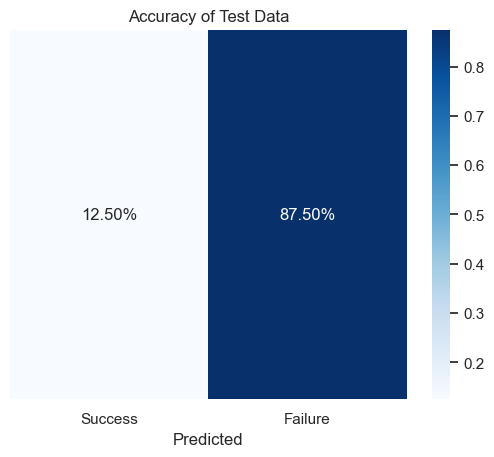

In [78]:
# Categorize the predictions as success or failure
success = np.abs(testing["price"] - predictions) <= 100
failure = ~success

# Create a confusion matrix
confusion_matrix = np.array([[np.sum(success), np.sum(failure)]])

# Normalize the confusion matrix
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap to visualize the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='.2%', cmap='Blues', xticklabels=["Success", "Failure"], yticklabels=[""])
plt.xlabel("Predicted")
plt.title("Accuracy of Test Data")
plt.show()

It is difficult to predict the exact value of rent. Above, I've checked to see which proportion of the testing data has the prediction within $100 of the actual, which is a significant window for rent variation.

The result is that 87.5% of the predictions on this data were categorized as failures. This is a very bad model.

Since I've limited myself to just a few variables which all happen to be collinear, there isn't much I can do in terms of creating a more accurate model. What I've learned, at least from this data, is that these variables are not good predictors of rental price generally.

There are most likely many factors contributing to the inaccuracy. A safe assumption is that location needs to be taken into account, or the model could be made per city / zip code. It's common for rural and city apartments with the same details to vary in price by more than $100.

Let's see if I can create a more accurate model looking only at a particular city. I look for the one with the most records.


In [79]:
apartments.cityname.value_counts()

cityname
Dallas         2852
Denver         2745
Los Angeles    2397
Las Vegas      1844
Arlington      1570
               ... 
Killdeer          1
Dudley            1
Harvard           1
Stem              1
Albertville       1
Name: count, Length: 2966, dtype: int64

I'm more interested in Denver than Dallas, so I'll try that. I'll divide the data into training and testing.


In [80]:
denver = apartments[apartments['cityname'] == 'Denver']
training_size = int(len(denver) * 0.9)
training = denver.sample(n=training_size, random_state=1)
testing = denver.loc[denver.index.difference(training.index)]

model = smf.ols(formula="price ~ square_feet * bedrooms * bathrooms", data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 116586.48190878077
R-squared: 0.6026545385258988


I experimented with model choices again, and found that taking into consideration the interaction between all three variables yields the highest R^2 value.


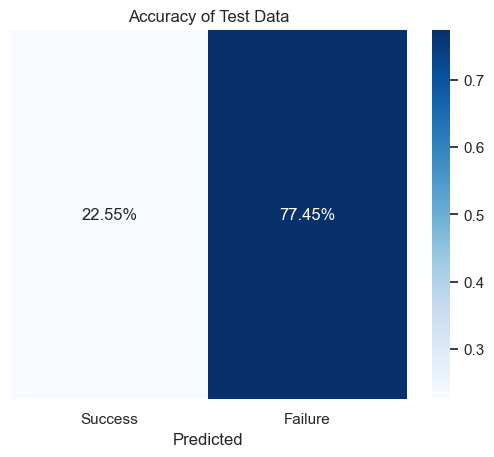

In [81]:
# Categorize the predictions as success or failure
success = np.abs(testing["price"] - predictions) <= 100
failure = ~success

# Create a confusion matrix
confusion_matrix = np.array([[np.sum(success), np.sum(failure)]])

# Normalize the confusion matrix
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap to visualize the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='.2%', cmap='Blues', xticklabels=["Success", "Failure"], yticklabels=[""])
plt.xlabel("Predicted")
plt.title("Accuracy of Test Data")
plt.show()

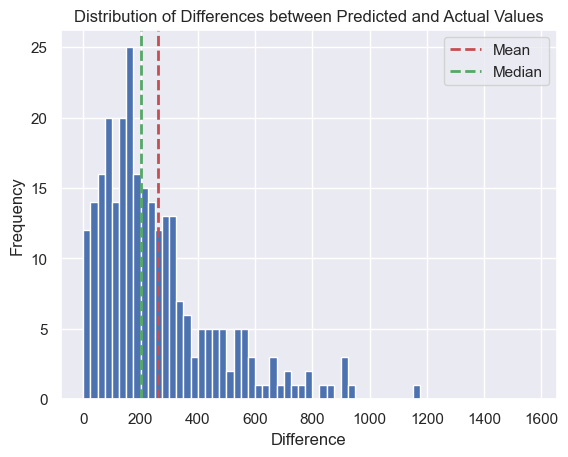

In [82]:
# Calculate the differences between the predicted and actual values
differences = np.abs(testing["price"] - predictions)

# Calculate the mean and median of the differences
mean_diff = np.mean(differences)
median_diff = np.median(differences)

# Create a histogram with buckets of size 25
plt.hist(differences, bins=range(0, int(max(differences)), 25))

# Add vertical lines for the mean and median
plt.axvline(mean_diff, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_diff, color='g', linestyle='dashed', linewidth=2, label='Median')

# Add labels, title, and legend
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Differences between Predicted and Actual Values")
plt.legend()

# Show the plot
plt.show()

It's interesting that using "price ~ square_feet" give accuracy along the same lines as "price ~ square_feet + bedrooms \* bathrooms".

I'm going to try one more thing to see if I can create a model... process the amenities column and create additional features. (**Feature Engineering**)


In [ ]:
bag_of_amenities = {}

for amenity_list in amenities.dropna().tolist():
    words = amenity_list.split(',')
    for word in words:
        word = word.strip()
        if word in bag_of_amenities:
            bag_of_amenities[word] += 1
        else:
            bag_of_amenities[word] = 1

amenities_processed = pd.Series(bag_of_amenities).sort_values(ascending=False)

unique_amenities = amenities_processed.index

# Create a feature column for each unique amenity
for amenity in unique_amenities:
    denver[amenity] = amenities.str.contains(amenity, na=False)

Here is my final attempt! It's a bit ridiculous to use every feature, but I want to see what happens.


In [84]:
training_size = int(len(denver) * 0.90)
training = denver.sample(n=training_size, random_state=1)
testing = denver.loc[denver.index.difference(training.index)]

In [85]:
model = smf.ols(formula='price ~ square_feet + bathrooms + bedrooms + \
       Parking + Pool + Gym + Q("Patio/Deck") + \
       Q("Washer Dryer") + Storage + Clubhouse + Dishwasher + AC + \
       Refrigerator + Fireplace + Q("Cable or Satellite") + Playground + \
       Q("Internet Access") + Q("Wood Floors") + Gated + Tennis + TV + Elevator + \
       Basketball + Q("Hot Tub") + Q("Garbage Disposal") + View + Alarm + Doorman + \
       Luxury + Golf', data=training)
results = model.fit()

predictions = results.predict(testing)

# Mean Squared Error
mse = np.mean((testing["price"] - predictions) ** 2)
print(f'Mean squared error: {mse}')

# R^2
sst = np.sum((testing["price"] - np.mean(testing["price"])) ** 2)
ssr = np.sum((predictions - np.mean(testing["price"])) ** 2)
r2 = ssr / sst
print(f'R-squared: {r2}')

Mean squared error: 91867.98018720289
R-squared: 0.709221757792847


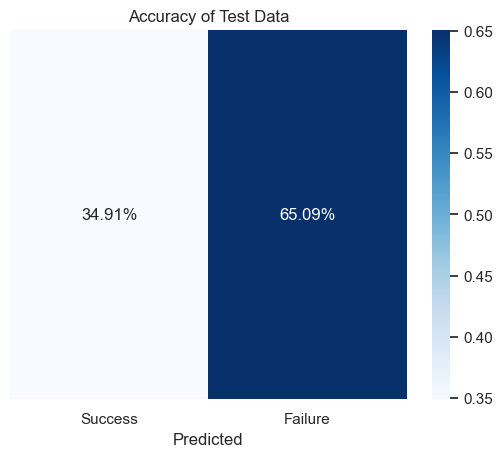

In [86]:
# Categorize the predictions as success or failure
success = np.abs(testing["price"] - predictions) <= 100
failure = ~success

# Create a confusion matrix
confusion_matrix = np.array([[np.sum(success), np.sum(failure)]])

# Normalize the confusion matrix
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap to visualize the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='.2%', cmap='Blues', xticklabels=["Success", "Failure"], yticklabels=[""])
plt.xlabel("Predicted")
plt.title("Accuracy of Test Data")
plt.show()

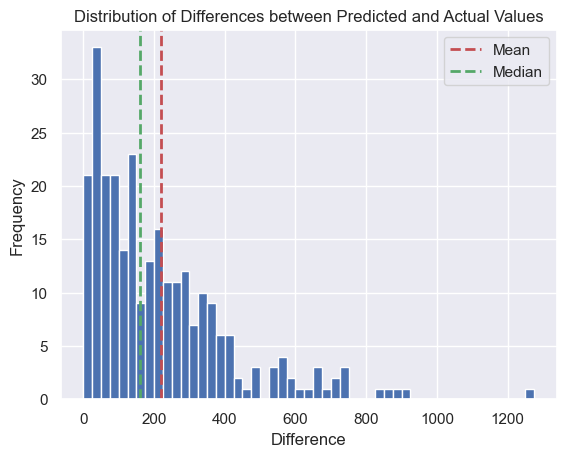

In [87]:
# Calculate the differences between the predicted and actual values
differences = np.abs(testing["price"] - predictions)

# Calculate the mean and median of the differences
mean_diff = np.mean(differences)
median_diff = np.median(differences)

# Create a histogram with buckets of size 25
plt.hist(differences, bins=range(0, int(max(differences)), 25))

# Add vertical lines for the mean and median
plt.axvline(mean_diff, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_diff, color='g', linestyle='dashed', linewidth=2, label='Median')

# Add labels, title, and legend
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Differences between Predicted and Actual Values")
plt.legend()

# Show the plot
plt.show()

In [88]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     98.12
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:07:52   Log-Likelihood:                -17832.
No. Observations:                2470   AIC:                         3.572e+04
Df Residuals:                    2440   BIC:                         3.590e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         606.0786     24.879     24.361      0.000     557.293     654.864
Parking[T.True]                   -93.9029     15.670     -5.992      0.000    -124.631     -63.175
Pool[T.True]                       10.5713     18.337      0.576      0.564     -25.387      46.529
Gym[T.True]                        36.0245     19.856      1.814      0.070      -2.912      74.961
Q("Patio/Deck")[T.True]            -7.2385     19.195     -0.377      0.706     -44.880      30.403
Q("Washer Dryer")[T.True]         -57.2272     19.831     -2.886      0.004     -96.114     -18.340
Storage[T.True]                   200.5148     17.594     11.397      0.000     166.014     235.015
Clubhouse[T.True]                 -39.5391     22.978     -1.721      0.085     -84.598       5.519
Dishwasher[T.True]                -94.1073     40.538     -2.321      0.020    -173.600     -14.615
AC[T.True]                        -94.8399     26.285     -3.608      0.000    -146.384     -43.296
Refrigerator[T.True]              271.5276     39.400      6.892      0.000     194.266     348.789
Fireplace[T.True]                 -99.7974     20.184     -4.944      0.000    -139.376     -60.218
Q("Cable or Satellite")[T.True]  -188.9382     44.687     -4.228      0.000    -276.566    -101.310
Playground[T.True]                -24.4520     35.228     -0.694      0.488     -93.531      44.627
Q("Internet Access")[T.True]      -24.5657     31.173     -0.788      0.431     -85.693      36.562
Q("Wood Floors")[T.True]            5.5530     24.794      0.224      0.823     -43.067      54.173
Gated[T.True]                     122.1900     37.352      3.271      0.001      48.945     195.435
Tennis[T.True]                   -194.9107     47.686     -4.087      0.000    -288.419    -101.402
TV[T.True]                        253.9557     32.637      7.781      0.000     189.957     317.954
Elevator[T.True]                    2.5256     37.361      0.068      0.946     -70.736      75.787
Basketball[T.True]               -124.4605     48.849     -2.548      0.011    -220.251     -28.670
Q("Hot Tub")[T.True]               46.7186     25.086      1.862      0.063      -2.472      95.910
Q("Garbage Disposal")[T.True]     -32.9122     59.844     -0.550      0.582    -150.263      84.439
View[T.True]                       15.3765     24.581      0.626      0.532     -32.826      63.579
Alarm[T.True]                    5.316e-11    2.1e-11      2.536      0.011    1.21e-11    9.43e-11
Doorman[T.True]                  1535.1595    343.169      4.473      0.000     862.228    2208.091
Luxury[T.True]                    -18.9353    149.226     -0.127      0.899    -311.557     273.687
Golf[T.True]                      -81.7054    344.866     -0.237      0.813    -757

Well, I wasn't expecting this to work because it should be over-fit, but it did give a 15% improvement using feature engineering. The collinear nature of square feet and number of rooms was a problem, and I learned that there isn't a clear rent increase for simply having a feature. There is a lot more nuance to setting rent prices, ranging from age of the building, location, and condition, which are not really reflected in the data/model.

For example, lots of apartments might have a pool, but is the pool in a condition that people would want to use it? That kind of information doesn't appear here, so it's not particularly helpful. We would need to know the distribution of pool quality, which could probably be measured better with another metric, such as building age / time since last renovation.

If I had to start the project over again, I wouldn't choose a linear model. I would use a clustering algorithm to try to find the most similar candidates from the training set. Because location matters so much in rental price, it makes sense to start there. A square foot in New York doesn't fetch the same rent as a square foot in the middle of a corn field.

I thought that there would be a very interpretable, linear relationship for price from some simple variables, but I was flat out wrong. My main takeaway from this project is how important exploratory data analysis is, particularly the analysis that goes into choosing variables and models. The way the course is set up, we were told to pick a model before trying it, and I guess that's a missed step—it's necessary to try out a bunch of different models to see how they perform.
